In [1]:
from UTILITY_quickstart import *

In [2]:
tao = initializeTao(
    inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5',
    #inputBeamFilePathSuffix = '/beams/L0AFEND_facet2-lattice.h5',

    csrTF = True,
    numMacroParticles=1e3,
    #loadDefaultLatticeTF=False,
    lastTrackedElement="L0BFEND" #Initially, only want to load PInit. This is overriden in propagateToBEGBC20()

)

trackBeam(tao)
PInit = ParticleGroup(data=tao.bunch_data("L0AFEND"))

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to L0BFEND
CSR on
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_defaults.yml
Number of macro particles = 1000.0


In [3]:
targetBunchSpacing = 200e-6
makingChangesUpstreamOfBEGBC20 = True

def makeBoundsTuple(range, center): return tuple(sorted( ( (1-range)*center, (1+range)*center) ) )
#boundsRange = 0.5
quadBoundsRange = 0.5
sextBoundsRange = 1


pbounds = {
    # "QA10361kG": makeBoundsTuple(quadBoundsRange, getQuadkG(tao, "QA10361")),
    # "QA10371kG": makeBoundsTuple(quadBoundsRange, getQuadkG(tao, "QA10371")),
    # "QE10425kG": makeBoundsTuple(quadBoundsRange, getQuadkG(tao, "QE10425")),
    # "QE10441kG": makeBoundsTuple(quadBoundsRange, getQuadkG(tao, "QE10441")),
    # "QE10511kG": makeBoundsTuple(quadBoundsRange, getQuadkG(tao, "QE10511")),
    # "QE10525kG": makeBoundsTuple(quadBoundsRange, getQuadkG(tao, "QE10525")),
    
    'L1PhaseSet': (-30, -10),
    'L2PhaseSet': (-50, -30),
    
    #"B1EkG": makeBoundsTuple(boundsRange, 7.533),
    #"B2EkG": makeBoundsTuple(boundsRange, -10.942),
    #"B3EkG": makeBoundsTuple(boundsRange, 3.409),

    "Q1EkG": makeBoundsTuple(quadBoundsRange, getQuadkG(tao, "Q1EL")),
    "Q2EkG": makeBoundsTuple(quadBoundsRange, getQuadkG(tao, "Q2EL")),
    "Q3EkG": makeBoundsTuple(quadBoundsRange, getQuadkG(tao, "Q3EL_1")),
    "Q4EkG": makeBoundsTuple(quadBoundsRange, getQuadkG(tao, "Q4EL_1")),
    "Q5EkG": makeBoundsTuple(quadBoundsRange, getQuadkG(tao, "Q5EL")),
    "Q6EkG": makeBoundsTuple(quadBoundsRange, getQuadkG(tao, "Q6E")),
    
    "S1ELkG": makeBoundsTuple(sextBoundsRange, getSextkG(tao, "S1EL")),
    "S2ELkG": makeBoundsTuple(sextBoundsRange, getSextkG(tao, "S2EL")),
    "S3ELkG": makeBoundsTuple(sextBoundsRange, getSextkG(tao, "S3EL_1")),
    "S3ERkG": makeBoundsTuple(sextBoundsRange, getSextkG(tao, "S3ER_1")),
    "S2ERkG": makeBoundsTuple(sextBoundsRange, getSextkG(tao, "S2ER")),
    "S1ERkG": makeBoundsTuple(sextBoundsRange, getSextkG(tao, "S1ER")),
}

# Optimization

## Utility functions

In [4]:
def propagateToBEGBC20(
    centerXYatBEGBC20 = False    
): 

    ##################################
    #Propagate to BEGBC20 and save result
    ##################################
    makeBeamActiveBeamFile(PInit)
    
    tao.cmd(f'set beam_init track_start = L0AFEND')
    lastTrackedElement = "BEGBC20"
    tao.cmd(f'set beam_init track_end = {lastTrackedElement}')

    trackBeam(tao)

    P = ParticleGroup(data=tao.bunch_data(lastTrackedElement))

    ##################################
    #Optional!! Center in x and y
    ##################################
    if centerXYatBEGBC20:
        print(f"""Centering beam at BEGBC20, old values (x, xp, y, yp): {P["mean_x"]} ,{P["mean_xp"]}, {P["mean_y"]} ,{P["mean_yp"]} """)
        P.x = P.x - np.mean(P.x)
        P.y = P.y - np.mean(P.y)
        P.px = P.px - np.mean(P.px)
        P.py = P.py - np.mean(P.py)
    
    makeBeamActiveBeamFile(P)

    return

In [5]:
def prepareToSimulateFromBEGBC20toEnd():
    #####################################################
    #Import the BEGBC20 beam and prepare to simulate to end
    #####################################################

    tao.cmd(f'set beam_init track_start = BEGBC20')
    tao.cmd(f'set beam_init track_end = end')
    tao.cmd('reinit beam')

    return

## Optimizer functions

In [6]:
#If we're not making changes upstream, we can just calculate once
#makingChangesUpstreamOfBEGBC20 = True #Moved to top of notebook

if not makingChangesUpstreamOfBEGBC20:
    setLattice(tao) #Set lattice to current default config
    propagateToBEGBC20(centerXYatBEGBC20 = True)
    prepareToSimulateFromBEGBC20toEnd()

def rampToZero(val, thresh, scale = 1):
    return (max(val, thresh) - thresh) / scale

def specificOptimizer(
    self,
    **kwargs
):

    self.totalNumEvals += 1
    self.displayEvals()

    savedData = kwargs
    
    badValue = -1e300  #The value returned for illegal config. Should be colossal. Double limit ~= 1e308
    bigCost  = 1e50   #Should be large enough to dominate any "normal" return value but be dominated by badValue
    
    try: #This try block deals with bad configurations. Instead of causing the optimizer to halt we now 'except' a low value
        setLattice(tao, **kwargs)

    except:
        return badValue * 5

    if makingChangesUpstreamOfBEGBC20:
        try:
            propagateToBEGBC20(centerXYatBEGBC20 = True)
            prepareToSimulateFromBEGBC20toEnd()
        
        except:
            return badValue * 4

    try:
        trackBeam(tao)

    except:
        return badValue * 3

    BEGBC20NumLiveParticles = tao.bunch_params("BEGBC20")['n_particle_live']
    PENTNumLiveParticles = tao.bunch_params("PENT")['n_particle_live']

    if PENTNumLiveParticles < 10:
        return badValue * 2 

    
    # 2024-05-22 NO NO NO! These bunch_params calls are actually returning lattice info because fuck me
    #PENTEmitX = tao.bunch_params("PENT")['twiss_norm_emit_x']
    #PENTEmitY = tao.bunch_params("PENT")['twiss_norm_emit_y']
    #PENTSigmaZ = tao.bunch_params("PENT")['twiss_sigma_z']

    # PPENT =  ParticleGroup(data=tao.bunch_data("PENT"))
    # PPENT = PPENT[PPENT.status==1]

    # PENTEmitX = PPENT["norm_emit_x"]
    # PENTEmitY = PPENT["norm_emit_y"]
    # PENTSigmaZ = PPENT["sigma_t"]*3e8 #Cannot use std.("z") since Bmad dumps all particles at same z
    
    try: 
        P = getBeamAtElement(tao, "PENT")
        PDrive, PWitness = getDriverAndWitness(P)
    

        for PActiveStr in ["PDrive", "PWitness"]:
            PActive = locals()[PActiveStr]
            for val in ["mean_x", "mean_y", "sigma_x", "sigma_y"]:
                savedData[f"{PActiveStr}_{val}"] = PActive[val]
                #print(f"""{PActiveStr}_{val} = {PActive[val]}""")

            #Note that this is not a standard deviation; also imposes cost for being off zero
            savedData[f"{PActiveStr}_xCost"] = np.sqrt(np.mean((PActive.x)**2))
            savedData[f"{PActiveStr}_yCost"] = np.sqrt(np.mean((PActive.y)**2))


            #Using the product was making it report flat beams...
            #savedData[f"{PActiveStr}_totalCost"] = savedData[f"{PActiveStr}_xCost"] * savedData[f"{PActiveStr}_yCost"]
            #Instead, average
            savedData[f"{PActiveStr}_totalCost"] = 0.5*(savedData[f"{PActiveStr}_xCost"] + savedData[f"{PActiveStr}_yCost"])

            savedData[f"{PActiveStr}_emitSI90_x"] = smallestIntervalImpliedEmittance(PActive, plane = "x", percentage = 0.90)
            savedData[f"{PActiveStr}_emitSI90_y"] = smallestIntervalImpliedEmittance(PActive, plane = "y", percentage = 0.90)

            savedData[f"{PActiveStr}_zLen"] = smallestIntervalImpliedSigma(PActive.t * 3e8, percentage=0.9)

            savedData[f"{PActiveStr}_zCentroid"] = np.median(PActive.t * 3e8)

        savedData["bunchSpacing"] = savedData["PWitness_zCentroid"] - savedData["PDrive_zCentroid"]

        savedData["transverseCentroidOffset"] = np.sqrt(
                (savedData["PDrive_mean_x"] - savedData["PWitness_mean_x"])**2 + 
                (savedData["PDrive_mean_y"] - savedData["PWitness_mean_y"])**2
            )
            

    except:
        return badValue


    #Linear cost, weight by bunch
    #driveCostWeight = 0.1    
    #maximizeMe = 1 / (savedData["PWitness_totalCost"] + driveCostWeight * savedData["PDrive_totalCost"])

    #Ramp function cost
    #targetBunchSpacing = 100e-6 #Making this a global variable
    
    tolerableBeamOffset = 5e-6
    
    witnessTransverseSizeCostThreshold = 20e-6
    driveTransverseSizeCostThreshold = 20e-6

    driveEmittanceThreshold = 50e-6
    witnessEmittanceThreshold = 20e-6
    
    driveLengthCostThreshold =  0
    witnessLengthCostThreshold = 0

    

    # maximizeMe = 1 / (
    #     max(witnessCostThreshold, np.sqrt(savedData["PWitness_xCost"])) *  
    #     max(witnessCostThreshold, np.sqrt(savedData["PWitness_yCost"]))
    #     + driveCostWeight * savedData["PDrive_totalCost"]
    # )  


    #Using the product was making it prefer flat beams...
    # savedData["maximizeMe"] = 1 / (
    #     max(witnessTransverseSizeCostThreshold, np.sqrt(savedData["PWitness_xCost"])) +  
    #     max(witnessTransverseSizeCostThreshold, np.sqrt(savedData["PWitness_yCost"])) +
    #     driveTransverseCostWeight * np.sqrt(savedData["PDrive_xCost"]) +
    #     driveTransverseCostWeight * np.sqrt(savedData["PDrive_yCost"]) +
    #     max(driverLengthCostThreshold,  savedData["PDrive_zLen"]   ) +
    #     max(witnessLengthCostThreshold, savedData["PWitness_zLen"] ) 
    # )

    savedData["maximizeMe"] = 1 / np.mean([
        1e6 * rampToZero( abs(savedData["bunchSpacing"] - targetBunchSpacing), 10e-6, scale = 10e-6), 
        
        # 1e3 * rampToZero(abs(savedData["PWitness_mean_x"]), tolerableBeamOffset, scale = 1e-6),
        # 1e3 * rampToZero(abs(savedData["PWitness_mean_y"]), tolerableBeamOffset, scale = 1e-6),
        # 1e3 * rampToZero(abs(savedData["PDrive_mean_x"]  ), tolerableBeamOffset, scale = 1e-6),
        # 1e3 * rampToZero(abs(savedData["PDrive_mean_y"]  ), tolerableBeamOffset, scale = 1e-6),

        1e3 * rampToZero(savedData["transverseCentroidOffset"], tolerableBeamOffset, scale = 1e-6),
  
        # rampToZero(savedData["PWitness_sigma_x"], witnessTransverseSizeCostThreshold, scale = 10e-6),  
        # rampToZero(savedData["PWitness_sigma_y"], witnessTransverseSizeCostThreshold, scale = 10e-6),
        # rampToZero(savedData["PDrive_sigma_x"],   driveTransverseSizeCostThreshold, scale = 10e-6), 
        # rampToZero(savedData["PDrive_sigma_y"],   driveTransverseSizeCostThreshold, scale = 10e-6),

        rampToZero(savedData["PDrive_emitSI90_x"],   driveEmittanceThreshold, scale = 10e-6),
        rampToZero(savedData["PDrive_emitSI90_y"],   driveEmittanceThreshold, scale = 10e-6),
        rampToZero(savedData["PWitness_emitSI90_x"], witnessEmittanceThreshold, scale = 10e-6),
        rampToZero(savedData["PWitness_emitSI90_y"], witnessEmittanceThreshold, scale = 10e-6),
        
        
        rampToZero(savedData["PDrive_zLen"],   driveLengthCostThreshold,   scale = 10e-6),
        rampToZero(savedData["PWitness_zLen"], witnessLengthCostThreshold,  scale = 10e-6) 
    ])
    
    

    #Use charge loss to impose cost
    worstNumLiveParticles = PENTNumLiveParticles
    chargeFractionLiving = worstNumLiveParticles / BEGBC20NumLiveParticles

    
    if chargeFractionLiving < 0.98:
        #If a gradient is desired
        #savedData["maximizeMe"] += bigCost * (1-chargeFractionLiving)

        #If it's just a threshold
        return badValue*0.5
  
    
    #Collect desired data as a pandas Series
    tmpData = pd.Series( savedData ) 
    self.history = pd.concat([self.history, tmpData.to_frame().T])

    #Optional: Write to file
    self.history.to_json('optimizerHistory.json', orient='records')
    
    self.updatePlot()


    return savedData["maximizeMe"]



# def optimizerWrapper( self,
#                      #QA10361kG, QA10371kG, QE10425kG, QE10441kG, QE10511kG, QE10525kG,
#                      L1PhaseSet, L2PhaseSet, 
#                      #B1EkG, B2EkG, B3EkG,
#                      Q1EkG, Q2EkG, Q3EkG, Q4EkG, Q5EkG, Q6EkG,
#                      S1ELkG, S2ELkG, S3ELkG, 
#                      S3ERkG, S2ERkG, S1ERkG,
#                      **kwargs ):
#     return specificOptimizer(
#         self,
#         **{

#             # "QA10361kG": QA10361kG, 
#             # "QA10371kG": QA10371kG,
#             # "QE10425kG": QE10425kG,
#             # "QE10441kG": QE10441kG,
#             # "QE10511kG": QE10511kG,
#             # "QE10525kG": QE10525kG,
            
#             "L1PhaseSet": L1PhaseSet, 
#             "L2PhaseSet": L2PhaseSet,
            
#             #"B1EkG": B1EkG,
#             #"B2EkG": B2EkG,
#             #"B3EkG": B3EkG,
            
#             "Q1EkG" : Q1EkG,
#             "Q2EkG" : Q2EkG,
#             "Q3EkG" : Q3EkG,
#             "Q4EkG" : Q4EkG,
#             "Q5EkG" : Q5EkG,
#             "Q6EkG" : Q6EkG,
            
#             "S1ELkG": S1ELkG,
#             "S2ELkG": S2ELkG,
#             "S3ELkG": S3ELkG,
#             "S3ERkG": S3ERkG,
#             "S2ERkG": S2ERkG,
#             "S1ERkG": S1ERkG,
#             # "S3ERkG": S3ELkG, #Symmetry approx
#             # "S2ERkG": S2ELkG, #Symmetry approx
#             # "S1ERkG": S1ELkG, #Symmetry approx
            
#         }
#     )


# Function to create optimizerWrapper based on pbounds
def create_optimizer_wrapper(pbounds):
    param_names = list(pbounds.keys())
    
    def optimizerWrapper(self, **kwargs):
        params = {name: kwargs.get(name, None) for name in param_names}
        if None in params.values():
            raise ValueError("All parameters must be provided")
        return specificOptimizer(self, **params)
    
    return optimizerWrapper

# Create the optimizerWrapper function
optimizerWrapper = create_optimizer_wrapper(pbounds)

In [7]:
?optimizerWrapper

Signature: optimizerWrapper(self, **kwargs)
Docstring: <no docstring>
File:      /var/folders/3j/4b_6gm4j44z6mpdlh3f3ggjc0000gn/T/ipykernel_70750/4069455314.py
Type:      function

## Do optimization

### General optimizer setup

In [8]:
class OptimizationProblem:
    def __init__(self):
        self.history = pd.DataFrame()
        self.totalNumEvals = 0
        self.plot_display_handle = None
        self.evals_display_handle = None


    def updatePlot(self):
        plt.figure()
        plotKey = "maximizeMe"
        plt.plot(np.arange(len(self.history[plotKey])), self.history[plotKey], '-')
        
        plt.title('Optimization History')
        plt.xlabel('Evaluation #')
        plt.ylabel(plotKey)
        plt.yscale('log')
        plt.grid(True)
        
        
        if self.plot_display_handle is None:
            self.plot_display_handle = display(plt.gcf(), display_id=True)
        else:
            update_display(plt.gcf(), display_id=self.plot_display_handle.display_id)
        plt.close()

    def displayEvals(self):
        if self.evals_display_handle is None:
            self.evals_display_handle = display(f"Total Num Evals: {self.totalNumEvals}", display_id=True)
        else:
            update_display(f"Total Num Evals: {self.totalNumEvals}", display_id=self.evals_display_handle.display_id)

# Attach the function to the class as a method
OptimizationProblem.optimizerWrapper = optimizerWrapper

# Instantiate the optimization problem
problem = OptimizationProblem()

In [9]:
# Bounded region of parameter space
#2024-05-15: Out of abundance of caution, always comment out unused vars, even if using **kwargs stops errors from being thrown
# pbounds = {
#     #'L1PhaseSet': (-40, -20),
#     #'L2PhaseSet': (-50, -30),
    
#     #"B1EkG": makeBoundsTuple(boundsRange, 7.533),
#     #"B2EkG": makeBoundsTuple(boundsRange, -10.942),
#     #"B3EkG": makeBoundsTuple(boundsRange, 3.409),

#     "Q1EkG": makeBoundsTuple(quadBoundsRange, 161.311),
#     "Q2EkG": makeBoundsTuple(quadBoundsRange, -154.229),
#     "Q3EkG": makeBoundsTuple(quadBoundsRange, 110.217),
#     "Q4EkG": makeBoundsTuple(quadBoundsRange, 132.268),
#     "Q5EkG": makeBoundsTuple(quadBoundsRange, -23.373),
#     "Q6EkG": makeBoundsTuple(quadBoundsRange, -142.271),

#      "S1ELkG": makeBoundsTuple(sextBoundsRange, 804.871),
#      "S2ELkG": makeBoundsTuple(sextBoundsRange, -2049.489),
#      "S3ELkG": makeBoundsTuple(sextBoundsRange, -1019.3230),
#      "S3ERkG": makeBoundsTuple(sextBoundsRange, -1019.3230),
#      "S2ERkG": makeBoundsTuple(sextBoundsRange, -2049.489),
#      "S1ERkG": makeBoundsTuple(sextBoundsRange, 804.871),
# }

### Bayesian optimization

In [10]:
# optimizer = bayes_opt.BayesianOptimization(
#     f=problem.optimizerWrapper,
#     pbounds=pbounds,
#     random_state=7,
#     allow_duplicate_points=True, #2024-04-26 it was whining about this,
#     verbose = 0 #2024-05-22: Make it quiet
# )

# #Initial point(s) to check
# optimizer.probe(
#     params={
# 'Q1EkG': 117.05888832887702,
#  'Q2EkG': -161.08070347179788,
#  'Q3EkG': 123.62696608961151,
#  'Q4EkG': 99.94203817364581,
#  'Q5EkG': -31.456534919110677,
#  'Q6EkG': -105.01493924928589,
#  'S1ELkG': 453.142910378237,
#  'S2ELkG': -1988.4701652598128,
#  'S3ELkG': -985.7586439934659,
#  'S3ERkG': -564.5394965036853,
#  'S2ERkG': -1592.1135118613981,
#  'S1ERkG': 869.2610562040793
# },
#     lazy=True,
# )

# #Refer to https://bayesian-optimization.github.io/BayesianOptimization/exploitation_vs_exploration.html
# #and https://github.com/bayesian-optimization/BayesianOptimization/blob/master/bayes_opt/bayesian_optimization.py
# boInitialKappa = 10 + 0*10.
# boFinalKappa = 1e-3 + 0*0.1
# boNumIter = 1000
# boKappaDecay = (boFinalKappa / boInitialKappa)**(1/boNumIter)

# acquisition_function = bayes_opt.util.UtilityFunction(kind='ucb',
#                                    kappa=boInitialKappa,         #Default 2.576
#                                    xi=0.0,              #Default 0
#                                    kappa_decay=boKappaDecay,       #Default 0
#                                    kappa_decay_delay=0  #Default 0                     
#                                           )


# optimizer.maximize(
#     init_points=0, #Initial, random points
#     n_iter=boNumIter,
#     acquisition_function=acquisition_function
# )

### Differential evolution

In [11]:
from scipy.optimize import differential_evolution

# Convert pbounds to the format required by differential_evolution
bounds = [(low, high) for (low, high) in pbounds.values()]
param_names = list(pbounds.keys())

#scipy.optimize wants to optimize a function which is passed a vector of all the parameters
#This programmatically wraps the existing wrapper (ugh...) to handle this format
def create_DE_wrapper(obj, param_names):
    def wrapperDE(params):
        param_dict = dict(zip(param_names, params))

        #bayes_opt is a maximizer but differential_evolution is a minimizer... hence the inversion
        return -1*obj.optimizerWrapper(**param_dict)
    
    return wrapperDE

wrapperDE = create_DE_wrapper(problem, param_names)

In [12]:
import yaml
with open('setLattice_defaults.yml', 'r') as file:
    importedDefaultSettings = yaml.safe_load(file)

defaultSettingsVector = [importedDefaultSettings[key] for key in list(pbounds.keys())]

'Total Num Evals: 99'

Centering beam at BEGBC20, old values (x, xp, y, yp): -3.0124340575680825e-05 ,-1.632874309173036e-06, -2.784309305451359e-06 ,-1.3031440807726733e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


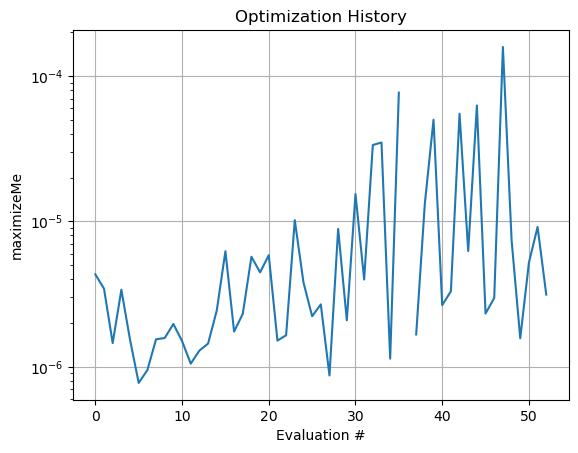

Centering beam at BEGBC20, old values (x, xp, y, yp): -3.4794071730939804e-05 ,-1.3124109828638279e-06, -2.6090150349215206e-06 ,-1.4174762552026264e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -3.3855629692273266e-05 ,-1.6208178546337193e-06, -2.8500212731846106e-06 ,-1.2593485356931196e-07 
WARNING! Expected drive/witness structure not found
Centering beam at BEGBC20, old values (x, xp, y, yp): -4.005004933643329e-05 ,-1.4990204449773316e-06, -2.8318400356162484e-06 ,-1.2836430271634554e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -1.1678879790535267e-05 ,-1.701142322799577e-06, -2.356984380905161e-06 ,-1.552852733928221e-07 
WARNING! Expected drive/witness structure not found
Centering beam at BEGBC20, old values (x, xp, y, yp): -5.820296151937959e-05 ,-1.8706956804263987e-06, -2.989918341006827e-06 ,-1.180674254588464e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -4.0687102790947966e-05 ,-1.4067320551910594e-06, -2.7587483998968993e-06 ,-1.3308929549455296e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -2.7719892581282086e-05 ,-1.5417593471620436e-06, -2.6999101814641416e-06 ,-1.3576851203524566e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -1.9517649264590418e-05 ,-1.837928899625415e-06, -2.6803324722632193e-06 ,-1.3600284900325725e-07 
WARNING! Expected drive/witness structure not found
Centering beam at BEGBC20, old values (x, xp, y, yp): -1.3820073584392367e-05 ,-1.400121849431678e-06, -2.2505339399831413e-06 ,-1.6203865506712607e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -2.111471507634079e-05 ,-1.6449310298702028e-06, -2.6068827587750677e-06 ,-1.411754225214686e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -4.5196520391073914e-05 ,-1.4265407161848513e-06, -2.80405123392455e-06 ,-1.306235564419514e-07 
WARNING! Expected drive/witness structure not found
Centering beam at BEGBC20, old values (x, xp, y, yp): -3.508154042896852e-05 ,-1.2737460258744082e-06, -2.613500966868622e-06 ,-1.4158400862220058e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -2.985244648099117e-05 ,-2.2490771477761947e-06, -3.0024126774012357e-06 ,-1.161590557248722e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -5.061122571611451e-05 ,-1.6198502090640014e-06, -2.947468962874581e-06 ,-1.220344715079446e-07 
WARNING! Expected drive/witness structure not found
Centering beam at BEGBC20, old values (x, xp, y, yp): -3.129641413716064e-05 ,-2.6403742208989334e-06, -3.148062960989365e-06 ,-1.06741426

/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -1.4302788956310206e-05 ,-1.6168639941266174e-06, -2.39176857818617e-06 ,-1.535705942643256e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -3.972493743921764e-05 ,-2.65880168717534e-06, -3.1560615109285765e-06 ,-1.068775770688898e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -2.612058387173955e-05 ,-1.4375912912709932e-06, -2.6036060171728308e-06 ,-1.4168692140891479e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:202: RuntimeWarning: invalid value encountered in sqrt
  emit_opt = np.sqrt( sigmax_opt**2 * sigmaxp_opt**2 - (rho_opt * sigmax_opt * sigmaxp_opt)**2 )


Centering beam at BEGBC20, old values (x, xp, y, yp): -5.959773368837063e-05 ,-3.5921103258593725e-06, -3.4365212819379662e-06 ,-8.594891426308722e-08 
Centering beam at BEGBC20, old values (x, xp, y, yp): -2.2739135974214337e-05 ,-1.6347071041436847e-06, -2.643060728772647e-06 ,-1.3944042284048129e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -2.0668549189000963e-05 ,-1.614197488146392e-06, -2.568947884577982e-06 ,-1.4363776337276225e-07 
differential_evolution step 1: f(x)= -4.31478e-06


/opt/homebrew/anaconda3/envs/bmad/lib/python3.11/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Centering beam at BEGBC20, old values (x, xp, y, yp): -3.4310185239552574e-05 ,-1.418121964029789e-06, -2.713604429290467e-06 ,-1.351229381862669e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -4.2155786846590913e-05 ,-1.8521392655178398e-06, -2.985695823176498e-06 ,-1.1782299668946119e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -2.458300857901651e-05 ,-1.5869363560808484e-06, -2.6450057247877174e-06 ,-1.388615416376517e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -3.4727840700706914e-05 ,-1.6647138340461363e-06, -2.866797432486389e-06 ,-1.2451277984413505e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -3.4654131549618086e-05 ,-2.3592241110428053e-06, -3.074165771082401e-06 ,-1.1236464218521807e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -4.340654028840297e-05 ,-1.9454976539726104e-06, -3.0202073598793888e-06 ,-1.1651229755614773e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -2.813851201695299e-05 ,-1.5247616978588434e-06, -2.691923752139662e-06 ,-1.36349847772033e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -2.812265117263117e-05 ,-1.5260536506788521e-06, -2.696192486092449e-06 ,-1.3602689072877227e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -5.4379572445065914e-05 ,-2.997191206559582e-06, -3.229474108868243e-06 ,-1.0197622378782496e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -2.2642701186239782e-05 ,-1.6453946809730244e-06, -2.6457552229340873e-06 ,-1.3937547908164331e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -2.4391667437180825e-05 ,-1.6581664704656161e-06, -2.694916424632633e-06 ,-1.358384087523466e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


differential_evolution step 2: f(x)= -4.31478e-06


/opt/homebrew/anaconda3/envs/bmad/lib/python3.11/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Centering beam at BEGBC20, old values (x, xp, y, yp): -2.246272856957133e-05 ,-1.583547336850136e-06, -2.595937926137602e-06 ,-1.4201749743806008e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -4.2043449203189874e-05 ,-1.8562792462835337e-06, -2.994966923898908e-06 ,-1.1724252328192e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -3.0057193432660108e-05 ,-1.6937597844612118e-06, -2.8279076218698796e-06 ,-1.2692696746559182e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -3.652295798189948e-05 ,-1.7644555835693344e-06, -2.9288354842553044e-06 ,-1.2077153662083397e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -3.110691709894496e-05 ,-2.025239918256087e-06, -2.943772548221524e-06 ,-1.198180091075373e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -2.6573905982568424e-05 ,-1.6727068707433828e-06, -2.745350589549446e-06 ,-1.3296469634532637e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -2.982541544773397e-05 ,-1.508481892793671e-06, -2.7237602879042616e-06 ,-1.3454600022459226e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -3.2509364143756804e-05 ,-1.509369553254976e-06, -2.756663850884693e-06 ,-1.3249183628361732e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -2.1195220859560017e-05 ,-1.6852017447671954e-06, -2.632737033244151e-06 ,-1.3931388953557099e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -1.969787898853332e-05 ,-1.6801275789075027e-06, -2.590480184192074e-06 ,-1.4252957150835368e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -3.0484733526149508e-05 ,-1.709815033510436e-06, -2.833534655120114e-06 ,-1.26547151241247e-07 
WARNING! Expected drive/witness structure not found
differential_evolution step 3: f(x)= -6.22185e-06


/opt/homebrew/anaconda3/envs/bmad/lib/python3.11/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Centering beam at BEGBC20, old values (x, xp, y, yp): -3.05494192764873e-05 ,-1.6759244517488866e-06, -2.8076327988513966e-06 ,-1.2836888938005772e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -3.0513362964157232e-05 ,-1.6606037790124256e-06, -2.8032804938569498e-06 ,-1.2859685682686218e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -2.671565146606388e-05 ,-1.934751629268323e-06, -2.8742261224800102e-06 ,-1.232013609833858e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -3.0106024553550924e-05 ,-1.9034450553350834e-06, -2.8952728163938357e-06 ,-1.2188150263621857e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -3.318780259749907e-05 ,-1.874652288808554e-06, -2.9235550597456215e-06 ,-1.1999997080222182e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -4.012816891514362e-05 ,-2.015776063542065e-06, -3.0025635259141196e-06 ,-1.169181157192125e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -2.9884471442184455e-05 ,-1.8427463049403203e-06, -2.878534716742331e-06 ,-1.2289568735746277e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -3.0993877028360464e-05 ,-1.5156726738509344e-06, -2.742073949828918e-06 ,-1.332681442892781e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -2.1163291593352238e-05 ,-1.6921064492387704e-06, -2.6296156034541504e-06 ,-1.3946883548580484e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -2.9447473885059687e-05 ,-1.5885937204182348e-06, -2.7621652594628005e-06 ,-1.323152656290061e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -2.455978631986602e-05 ,-1.6901094446354766e-06, -2.7166146559972706e-06 ,-1.343859013865352e-07 
differential_evolution step 4: f(x)= -1.01785e-05


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/opt/homebrew/anaconda3/envs/bmad/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/homebrew/anaconda3/envs/bmad/lib/python3.11/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Centering beam at BEGBC20, old values (x, xp, y, yp): -3.325190408540773e-05 ,-1.867763640428414e-06, -2.926303806946497e-06 ,-1.2018895919766687e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:202: RuntimeWarning: invalid value encountered in sqrt
  emit_opt = np.sqrt( sigmax_opt**2 * sigmaxp_opt**2 - (rho_opt * sigmax_opt * sigmaxp_opt)**2 )


Centering beam at BEGBC20, old values (x, xp, y, yp): -3.608142564972992e-05 ,-1.681113606137933e-06, -2.887894258647638e-06 ,-1.2307442966961568e-07 
WARNING! Expected drive/witness structure not found
Centering beam at BEGBC20, old values (x, xp, y, yp): -2.1366695400874903e-05 ,-2.3295696514087673e-06, -2.955037709148065e-06 ,-1.1914569852877017e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -4.0622212838792447e-05 ,-1.943613910300076e-06, -2.977327382636924e-06 ,-1.1845564824243857e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -3.0343332784608962e-05 ,-1.6794349556686595e-06, -2.810764856720905e-06 ,-1.28013555931399e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -4.440503997181803e-05 ,-2.162584471810306e-06, -3.0502621329890525e-06 ,-1.1446814653416778e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -2.9859270257773215e-05 ,-1.508780935506097e-06, -2.7185662351430297e-06 ,-1.347937435909516e-07 
WARNING! Expected drive/witness struc

/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -3.177699689294293e-05 ,-1.6713237975526215e-06, -2.8322706566943686e-06 ,-1.2687587773832488e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -4.647153838836215e-05 ,-1.6956353855531913e-06, -2.968026369417445e-06 ,-1.1915938644045217e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -2.6794501642491792e-05 ,-1.6915074134527522e-06, -2.7585084615439315e-06 ,-1.3152740131887641e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


differential_evolution step 5: f(x)= -1.01785e-05


/opt/homebrew/anaconda3/envs/bmad/lib/python3.11/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Centering beam at BEGBC20, old values (x, xp, y, yp): -3.3026593780151315e-05 ,-1.8933579835829161e-06, -2.923237074792497e-06 ,-1.2005968466127745e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -4.1973859688641665e-05 ,-2.339745517691608e-06, -3.0844803241009545e-06 ,-1.1225683919349349e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -1.947498577241978e-05 ,-2.3072052114379834e-06, -2.921068843043516e-06 ,-1.2093922864716361e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -2.744664122864713e-05 ,-2.158005773350264e-06, -2.962681297275029e-06 ,-1.1867389041413101e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -2.680170518279175e-05 ,-1.945863126941481e-06, -2.873720773870122e-06 ,-1.2310380601805175e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -3.6256199368469474e-05 ,-2.8623116430187657e-06, -3.2479439585796893e-06 ,-9.937007652998132e-08 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -3.063122487853932e-05 ,-1.962602524239856e-06, -2.9293126522882985e-06 ,-1.200242235226578e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:202: RuntimeWarning: invalid value encountered in sqrt
  emit_opt = np.sqrt( sigmax_opt**2 * sigmaxp_opt**2 - (rho_opt * sigmax_opt * sigmaxp_opt)**2 )


Centering beam at BEGBC20, old values (x, xp, y, yp): -2.5575463498040443e-05 ,-2.080417366280505e-06, -2.9071471132541834e-06 ,-1.2146981812763433e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -3.383532608443687e-05 ,-2.4461303479106373e-06, -3.084645631001574e-06 ,-1.1156460835491698e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:202: RuntimeWarning: invalid value encountered in sqrt
  emit_opt = np.sqrt( sigmax_opt**2 * sigmaxp_opt**2 - (rho_opt * sigmax_opt * sigmaxp_opt)**2 )


Centering beam at BEGBC20, old values (x, xp, y, yp): -4.655085091079956e-05 ,-1.68735310509868e-06, -2.9748624988891133e-06 ,-1.1888272338532652e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -2.666985961639716e-05 ,-1.701153349750764e-06, -2.749362683161369e-06 ,-1.3238909506264818e-07 
differential_evolution step 6: f(x)= -7.68281e-05


/opt/homebrew/anaconda3/envs/bmad/lib/python3.11/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Centering beam at BEGBC20, old values (x, xp, y, yp): -2.707110662158975e-05 ,-1.9616774663145287e-06, -2.882863518906946e-06 ,-1.2250548746865273e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -2.5066410165443897e-05 ,-2.1616667728932083e-06, -2.925199828168056e-06 ,-1.2038305966982802e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -1.3542198308173658e-05 ,-2.509030637040221e-06, -2.913286063772203e-06 ,-1.2140109970881912e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -3.7674268582240655e-05 ,-2.07696135700593e-06, -3.0017211740068753e-06 ,-1.1628463187208107e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -2.319381019573752e-05 ,-1.8995337262578552e-06, -2.7956071900211597e-06 ,-1.2759872263813448e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -1.3542044228752474e-05 ,-2.5122921189572837e-06, -2.9161556593754197e-06 ,-1.2141495464039132e-07 
WARNING! Expected drive/witness structure not found
Centering beam at BEGBC20, old values (x, xp, y, yp): -3.678959696131823e-05 ,-1.5234909982137287e-06, -2.8180999449186817e-06 ,-1.2859051270629093e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -2.33380430783611e-05 ,-2.5563279472478493e-06, -3.0615595343402442e-06 ,-1.1229107532865491e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -4.0276246275636534e-05 ,-1.7311769853440456e-06, -2.939086787424482e-06 ,-1.199775232764481e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -2.4199237251417215e-05 ,-2.4693592725033376e-06, -3.031779551451445e-06 ,-1.142638907128575e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -1.910425012586331e-05 ,-2.591482660591123e-06, -3.039492996445283e-06 ,-1.134238710620919e-07 
differential_evolution step 7: f(x)= -7.68281e-05
Centering beam at BEGBC20, old values (x, xp, y, yp): -3.070002366445012e-05 ,-2.1908359730060667e-06, -3.0052792525307013e-06 ,-1.167377563506589e-07 
Centering beam at BEGBC20, old values (x, xp, y, yp): -3.631676740948384e-05 ,-1.6865647462922083e-06, -2.9004786922186245e-06 ,-1.2236812898861325e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -3.137506044844759e-05 ,-1.9766403851021383e-06, -2.9403840408041997e-06 ,-1.193478099316446e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -2.7269649780459893e-05 ,-2.390249224910378e-06, -3.038936783374756e-06 ,-1.1417299310819536e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -2.75794349585602e-05 ,-2.1499312230607033e-06, -2.9606309672432974e-06 ,-1.1906022652810297e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -4.080537458308943e-05 ,-1.9605443025807517e-06, -2.990362797459118e-06 ,-1.1784397606146494e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -2.9889063878508387e-05 ,-1.5093908081703834e-06, -2.7168113231365655e-06 ,-1.3475005386241334e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -2.0516194472997217e-05 ,-2.1289374087851883e-06, -2.854093284966481e-06 ,-1.2441646417084015e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -4.023235082425731e-05 ,-1.729742047201489e-06, -2.9411249009972587e-06 ,-1.1997563776204732e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


Centering beam at BEGBC20, old values (x, xp, y, yp): -2.7653746669248113e-05 ,-1.9304869814538022e-06, -2.879018146239516e-06 ,-1.224973482178697e-07 


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:177: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


In [ ]:
#Optional: Define list of starting points
totalPopSize = 10  # Total population size
numDimensions = len(bounds)  # Number of parameters

#Uniformly distributed
# populationDE = np.random.rand(totalPopSize, numDimensions)
# for i in range(numDimensions):
#     low, high = bounds[i]
#     populationDE[:, i] = low + populationDE[:, i] * (high - low)

#Normally distributed
populationDE = np.zeros((totalPopSize, numDimensions))
for i in range(numDimensions):
    low, high = bounds[i]

    #Define mean based on bounds
    #mean = (high + low) / 2

    #Optional: Define mean based on defaultSettingsVector
    mean = defaultSettingsVector[i]
    
    std_dev = (high - low) / 20
    populationDE[:, i] = np.random.normal(mean, std_dev, totalPopSize)

#Optional: Add specific points to initial evaluation list
#populationDE = np.vstack([[ np.mean(i) for i in bounds ], populationDE])
populationDE = np.vstack([[ defaultSettingsVector ], populationDE])

result = differential_evolution(
    wrapperDE, 
    bounds,
    maxiter=100, 
    disp=True,
    polish = False, 
    init = populationDE
)


print(problem.history) 

## Check out results

In [ ]:
problem.history.to_csv('output_data.csv', index=False)

problem.history = problem.history.sort_values(by='maximizeMe', ascending=False)


bestConfigData = problem.history.iloc[0]
bestConfigDict = bestConfigData.to_dict()

print( bestConfigData ) 



setLattice(tao, **bestConfigDict)


trackBeam(tao)

P = getBeamAtElement(tao, "PENT")
PDrive, PWitness = getDriverAndWitness(P)

print(f"""P, sigma x: {P["sigma_x"]}""")
print(f"""PDrive, sigma x: {PDrive["sigma_x"]}""")
print(f"""PWitness, sigma x: {PWitness["sigma_x"]}""")

In [ ]:
bestConfigDict

In [ ]:
display(plotMod(P, 'x', 'y',  bins=300))
display(plotMod(P, 'x', 'pz', bins=300))
display(plotMod(P, 'x', 'xp', bins=300))
display(plotMod(P, 'y', 'yp', bins=300))
display(plotMod(P, 'delta_t', 'pz', bins=300))
display(slicePlotMod(P, 'norm_emit_x',n_slice=100))


In [ ]:
display(plotMod(PWitness, 'x', 'y',  bins=300))
display(plotMod(PWitness, 'x', 'pz', bins=300))
display(plotMod(PWitness, 'x', 'xp', bins=300))
display(plotMod(PWitness, 'y', 'yp', bins=300))
display(plotMod(PWitness, 'delta_t', 'pz', bins=300))
display(slicePlotMod(PWitness, 'norm_emit_x',n_slice=100))


In [ ]:
print(f"""P, sigma x: {P["sigma_x"]}""")
print(f"""PDrive, sigma x: {PDrive["sigma_x"]}""")
print(f"""PWitness, sigma x: {PWitness["sigma_x"]}""")

display(plotMod(P, 'x', 'y',  bins=300))
display(plotMod(PDrive, 'x', 'y',  bins=300))
display(plotMod(PWitness, 'x', 'y',  bins=300))

In [ ]:
P = getBeamAtElement(tao, "MFFF")

display(plotMod(P, 'x', 'xp', bins=300))
display(slicePlotMod(P, 'norm_emit_x',n_slice=100))